##### Import libraries

In [32]:
import pandas as pd # data analysis
import matplotlib.pyplot as plt # default plotting library (line below: make plotting in Jupyter possible)
import seaborn as sns # user friendly visualisations
import numpy as np
%matplotlib inline
import warnings # disable matplotlib warnings (you may not need that)
warnings.filterwarnings("ignore", module="matplotlib")

##### Set options for Pandas and Seaborn

In [13]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 800)
sns.set(style='ticks', context='poster')
sns.set_style("whitegrid")

In [3]:
!ls

My Apple Health Data Analysis.ipynb	    export.xml
Trip Data Analysis.ipynb		    export_cda.xml
Trip Vs Non-Trip Activity Comparison.ipynb  trips-df.csv
daily_apple_health_data.csv		    trips_from_Nov2014.txt


##### Load the dataframes

In [191]:
healthData = pd.read_csv('daily_apple_health_data.csv')
trips = pd.read_csv('trips-df.csv')

### Plan

The question is: how will we do this? I strongly believe in having a plan before any code is written, so let's think about it.
I think that the simplest idea would be to add an additional column into the health data, which will indicate if this is a trip or non-trip day.
So let's take a quick look at the data frames and execute some Python to achieve that

In [192]:
healthData.head(2)

,endDate,value
0,2014-12-01,1.18215
1,2014-12-02,4.13971


In [193]:
trips.head(2)

,From,To
0,2017-06-13,2017-06-20
1,2017-05-06,2017-05-17


In [208]:
# create a list of unique trip days and create new data frame
days = []
def getRanges(x):
    global days
    days = days + pd.date_range(x['From'], x['To']).date.tolist()

trips.apply(getRanges, axis=1)
daysDf = pd.DataFrame(list(set([str(d) for d in days])), columns=['Date'])
daysDf.head(2)

,Date
0,2016-10-25
1,2015-11-30


#### Merge health data with trips
- if Date is NaN -> it's a non-trip day
- if Date has a date string -> it's a trip day

In [209]:
merged = pd.merge(healthData, daysDf, how='left', left_on='endDate', right_on='Date')
merged.head()

,endDate,value,Date
0,2014-12-01,1.182150,NaN
1,2014-12-02,4.139710,NaN
2,2014-12-03,3.096390,NaN
3,2014-12-04,10.237749,NaN
4,2014-12-05,3.174237,NaN


#### So what's the % of time outside of Cork for Adam?

In [210]:
merged['isTrip'] = ~merged['Date'].isnull()
merged.head(2)

,endDate,value,Date,isTrip
0,2014-12-01,1.18215,NaN,False
1,2014-12-02,4.13971,NaN,False


In [211]:
daysOutOfHomeTown = merged.isTrip.value_counts()[0]
daysInHomeTown = merged.isTrip.value_counts()[1]
'~{} %'.format(round(daysInHomeTown / daysOutOfHomeTown * 100))

'~11.0 %'

#### Visualise data

In [214]:
# convert date to datetime
merged['endDate'] = pd.to_datetime(merged['endDate'])

In [ ]:
# dump the dataframe into csv file
merged.to_csv('merged.csv', index=False)

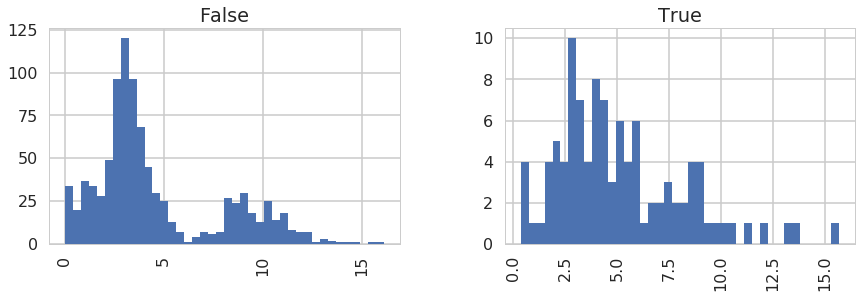

In [382]:
# show distribution for Non-trip and Trip periods
merged.hist(bins=40, figsize=(14,4), column='value', by='isTrip');

In [251]:
# https://plot.ly/python/getting-started/
import plotly 
plotly.tools.set_credentials_file(username='napora.adam', api_key='yizLbSGSvsxeQPsxhgd0') # Set credentials
plotly.tools.set_config_file(world_readable=True,sharing='public') # Set plotting options for a free account

In [324]:
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go

# Create lines
line2 = go.Scatter(
    x = merged[merged.isTrip == True]['endDate'],
    y = merged[merged.isTrip == True]['value'],
    mode = 'markers',
    name = 'Trip Time',
    connectgaps=False,
    line = dict(color = '#31708f', width = 3),
    marker = dict(symbol = 'cross')
)

line1 = go.Scatter(
    x = merged[merged.isTrip == False]['endDate'],
    y = merged[merged.isTrip == False]['value'],
    opacity = .7,
    mode = 'markers',
    name = 'Non-trip Time',
    connectgaps=False,
    line = dict(width = 2, color = '#f7ba7e'),
    fillcolor='#eeccaa',
    fill = 'tozeroy'
)

# Plot the plot
py.iplot([line1, line2], fill=True)

#### Avg Km/day for the time at home

In [321]:
nonTripAvgKm = round(merged[merged.isTrip == False]['value'].mean(), 2)
str(nonTripAvgKm)

'4.57'

#### Avg Km/day for the time during the trips

In [322]:
tripAvgKm = round(merged[merged.isTrip == True]['value'].mean(), 2)
str(tripAvgKm)

'5.11'

#### Calculate difference in meters between the averages for 2 time periods

In [323]:
(tripAvgKm - nonTripAvgKm) * 1000

540.0

#### Statistical test for the difference between 2 groups
Difference between 2 compared groups will be calculated using a t-test and expressed as a p-value (0 - 1.0). The lower the value - the more different 2 groups are. Usually we set a significance threshold (alpha value) of 0.05 above which 2 groups are not significantly different

In [350]:
tripKms = merged[merged.isTrip == True]['value']
nonTripKms = merged[merged.isTrip == False]['value']

##### Calculate variance in the 2 groups
If the variance is close enough - then we can use a standard t-test

In [379]:
print('Variance for trip time: {} and non-trip time: {}'.format(tripKms.var(), nonTripKms.var()))

Variance for trip time: 9.244541521354495 and non-trip time: 10.463310500459796


In [380]:
print('Std Dev for trip time: {} and non-trip time: {}'.format(tripKms.std(), nonTripKms.std()))

Std Dev for trip time: 3.040483764362917 and non-trip time: 3.2347040823636086


In [351]:
from scipy.stats import ttest_ind
pvalue = ttest_ind(tripKms, nonTripKms, nan_policy='omit').pvalue
pvalue

0.10383783030918442